# Classification on Diabetes Dataset

## Summary

## Introduction

## Methods & Results

### (1) Load relevant libraries

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10, warn = -1)

library(reticulate) 
library(tidyverse) 
library(tidymodels)
library(patchwork)
library(ROSE)

Loaded ROSE 0.0-4




### (2) Load data from the original source on the web

In [2]:
# do only once. Takes ages but it works. 
# This run the python script to extract file from uci in R

# py_run_file("/home/jovyan/work/data/raw/dataset_download.py")

In [10]:
# read out the raw csv
raw_diabetes_df <- read_csv("/home/jovyan/work/data/raw/cdc_diabetes_health_indicators.csv", show_col_types = FALSE)
head(raw_diabetes_df)

HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,⋯,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,40,1,0,0,0,0,1,⋯,0,5,18,15,1,0,9,4,3,0
0,0,0,25,1,0,0,1,0,0,⋯,1,3,0,0,0,0,7,6,1,0
1,1,1,28,0,0,0,0,1,0,⋯,1,5,30,30,1,0,9,4,8,0
1,0,1,27,0,0,0,1,1,1,⋯,0,2,0,0,0,0,11,3,6,0
1,1,1,24,0,0,0,1,1,1,⋯,0,2,3,0,0,0,11,5,4,0
1,1,1,25,1,0,0,1,1,1,⋯,0,2,0,2,0,1,10,6,8,0


### (3) Wrangle and cleans the data from its original
#### Check for NA values 
- There are no NAs present in this dataset

In [11]:
# (1) 
# Check for NA values; there are no NAs present in this dataset

na_check <- raw_diabetes_df %>%
  summarise_all(~ sum(is.na(.)))
na_check_new <- as.data.frame(t(na_check))
colnames(na_check_new) <- c("NA_Count")
na_check_new

,NA_Count
,<int>
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0


#### Check the number of unique values in each variable + covert dbl to factor
- Some factors are still in quantitative form - also refer to metadata for what to convert

In [12]:
# (2) check the number of unique values in each variable + covert dbl to factor

# Some factor are still in double form - also refer to metadata for what to convert

class_counts <- raw_diabetes_df %>% summarise_all(n_distinct)
class_counts_new <- as.data.frame(t(class_counts))
colnames(class_counts_new) <- c("Class_Counts")
class_counts_new

,Class_Counts
,<int>
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


- Many variables need to be converted to factor type, especially when applying ROSE
- The synthesis of balanced samples depends on the format of the data
- The following variables are not factorised:
    - `BMI`
    - `GenHlth`
    - `MentHlth`
    - `PhysHlth`

In [13]:
# These variables need to be converted to factor type, especially when applying ROSE
# Synthesis of balanced samples depends on the format of the data

# ----------------------------------------
# Converting the following columns to factor type

raw_diabetes_df <- raw_diabetes_df %>%
  mutate(across(!BMI, ~ factor(.)))

head(raw_diabetes_df, n = 5)

HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,⋯,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,1,40,1,0,0,0,0,1,⋯,0,5,18,15,1,0,9,4,3,0
0,0,0,25,1,0,0,1,0,0,⋯,1,3,0,0,0,0,7,6,1,0
1,1,1,28,0,0,0,0,1,0,⋯,1,5,30,30,1,0,9,4,8,0
1,0,1,27,0,0,0,1,1,1,⋯,0,2,0,0,0,0,11,3,6,0
1,1,1,24,0,0,0,1,1,1,⋯,0,2,3,0,0,0,11,5,4,0


#### Dataset balancing

- The dataset provided has about 86% of the people provided to not have diabetes.
- We seek to balance the dataset to mitigate bias towards the majority class, reduce the risk of overfitting, 

In [14]:
# (3) check how unbalance is the dataset + balance the data

# it's pretty unbalanced
target_result <- raw_diabetes_df %>%
  group_by(Diabetes_binary) %>%
  summarise(
    Count = n(),
    Proportion = n() / nrow(raw_diabetes_df)
  ) %>%
  ungroup()
print("Initial counts for diabetes")
target_result

# ----------------------------------------
# use ROSE to balance data by oversampling

set.seed(6)

balanced_raw_diabetes_df <- ROSE(Diabetes_binary ~ ., data = raw_diabetes_df, seed = 123)$data

balanced_target_result <- balanced_raw_diabetes_df %>%
  group_by(Diabetes_binary) %>%
  summarise(
    Count = n(),
    Proportion = n() / nrow(balanced_raw_diabetes_df)
  ) %>%
  ungroup()

balanced_target_result

[1] "Initial counts for diabetes"


Diabetes_binary,Count,Proportion
<fct>,<int>,<dbl>
0,218334,0.860667
1,35346,0.139333


Diabetes_binary,Count,Proportion
<fct>,<int>,<dbl>
0,126884,0.5001734
1,126796,0.4998266


#### Set balanced dataframe and split to training and testing
- The balanced dataset will be written into the `data/processed/` folder so that the steps above will not be mandatory to run the notebook each time.
- The balanced dataset will need to undergo refactoring again due to being freshly read from the `.csv` file.
- The dataset is split such that the proportion of `Diabetes_binary` is maintained for the training and testing sets.

In [15]:
# Write out balanced df into data/processed/ so we don't have to run all the step above each time
balanced_raw_diabetes_df %>% write_csv("/home/jovyan/work/data/processed/balanced_cdc_diabetes_health_indicators.csv")

In [17]:
# Then read it out again so we dont have to run the steps above
balanced_raw_diabetes_df <- read_csv("/home/jovyan/work/data/processed/balanced_cdc_diabetes_health_indicators.csv", show_col_types = FALSE)

# Have to refactor them again, since we are reading these from .csv again

balanced_raw_diabetes_df <- balanced_raw_diabetes_df %>%
  mutate(across(!BMI, ~ factor(.)))

In [18]:
# split the data into training and testing set 

set.seed(6)

diabetes_split <- initial_split(balanced_raw_diabetes_df, prop = 0.75, strata = Diabetes_binary)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)
head(diabetes_train)

HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,⋯,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,1,34.92399,0,0,0,1,0,0,⋯,0,2,0,0,0,0,11,4,7,0
0,1,1,26.82572,0,0,0,1,1,1,⋯,1,5,0,30,1,0,13,6,4,0
0,1,1,25.91322,1,0,0,1,0,1,⋯,0,2,0,0,0,0,7,5,8,0
0,1,1,17.66171,1,0,0,1,0,1,⋯,0,3,0,0,0,1,8,6,7,0
1,1,1,29.68202,0,0,0,1,0,0,⋯,0,4,0,30,1,1,13,6,7,0
0,0,1,29.37924,0,0,0,1,0,0,⋯,0,3,0,0,0,1,1,6,8,0


In [19]:
class_counts_2 <- sapply(diabetes_train, function(x) length(unique(x)))
class_counts_2

HighBP             HighChol            CholCheck 
                   2                    2                    2 
                 BMI               Smoker               Stroke 
              190260                    2                    2 
HeartDiseaseorAttack         PhysActivity               Fruits 
                   2                    2                    2 
             Veggies    HvyAlcoholConsump        AnyHealthcare 
                   2                    2                    2 
         NoDocbcCost              GenHlth             MentHlth 
                   2                    5                   31 
            PhysHlth             DiffWalk                  Sex 
                  31                    2                    2 
                 Age            Education               Income 
                  13                    6                    8 
     Diabetes_binary 
                   2

### (4) Exploratory data analysis on training set

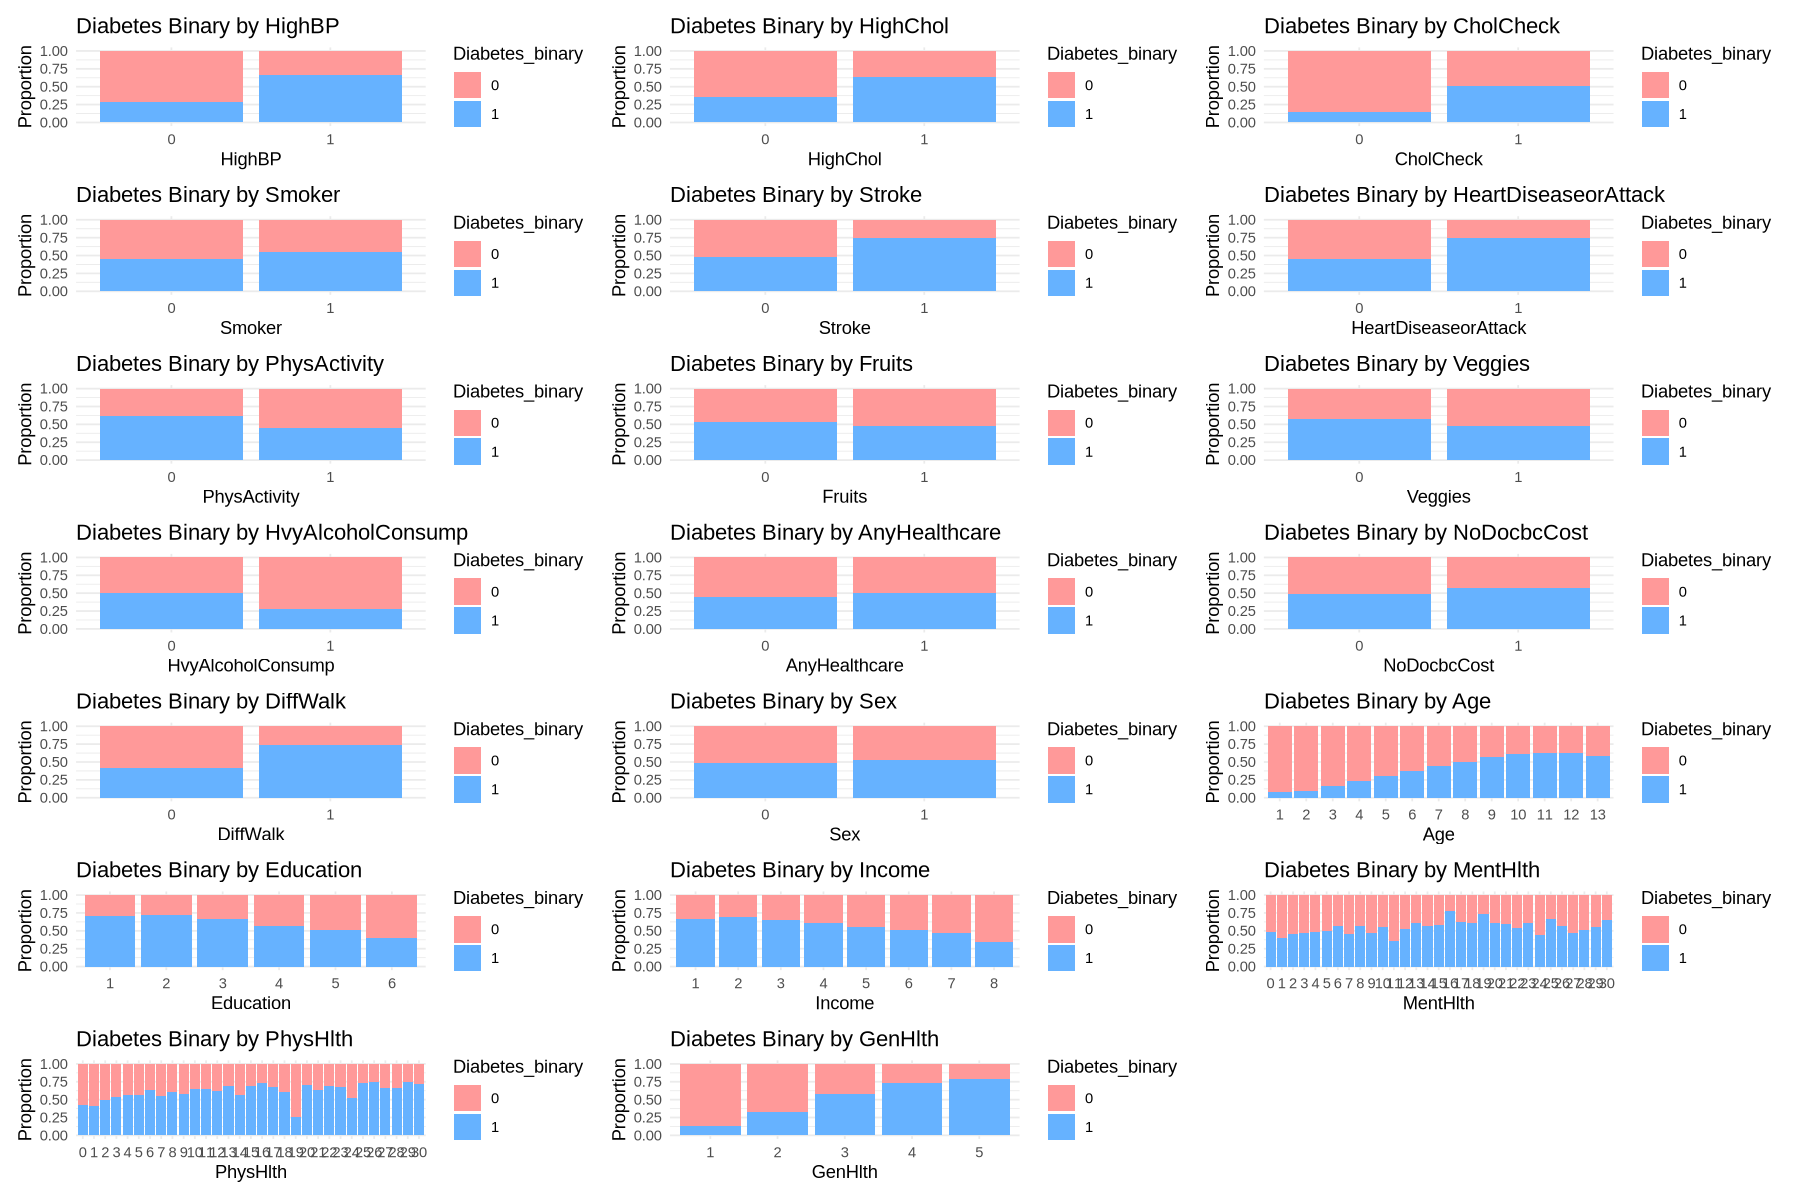

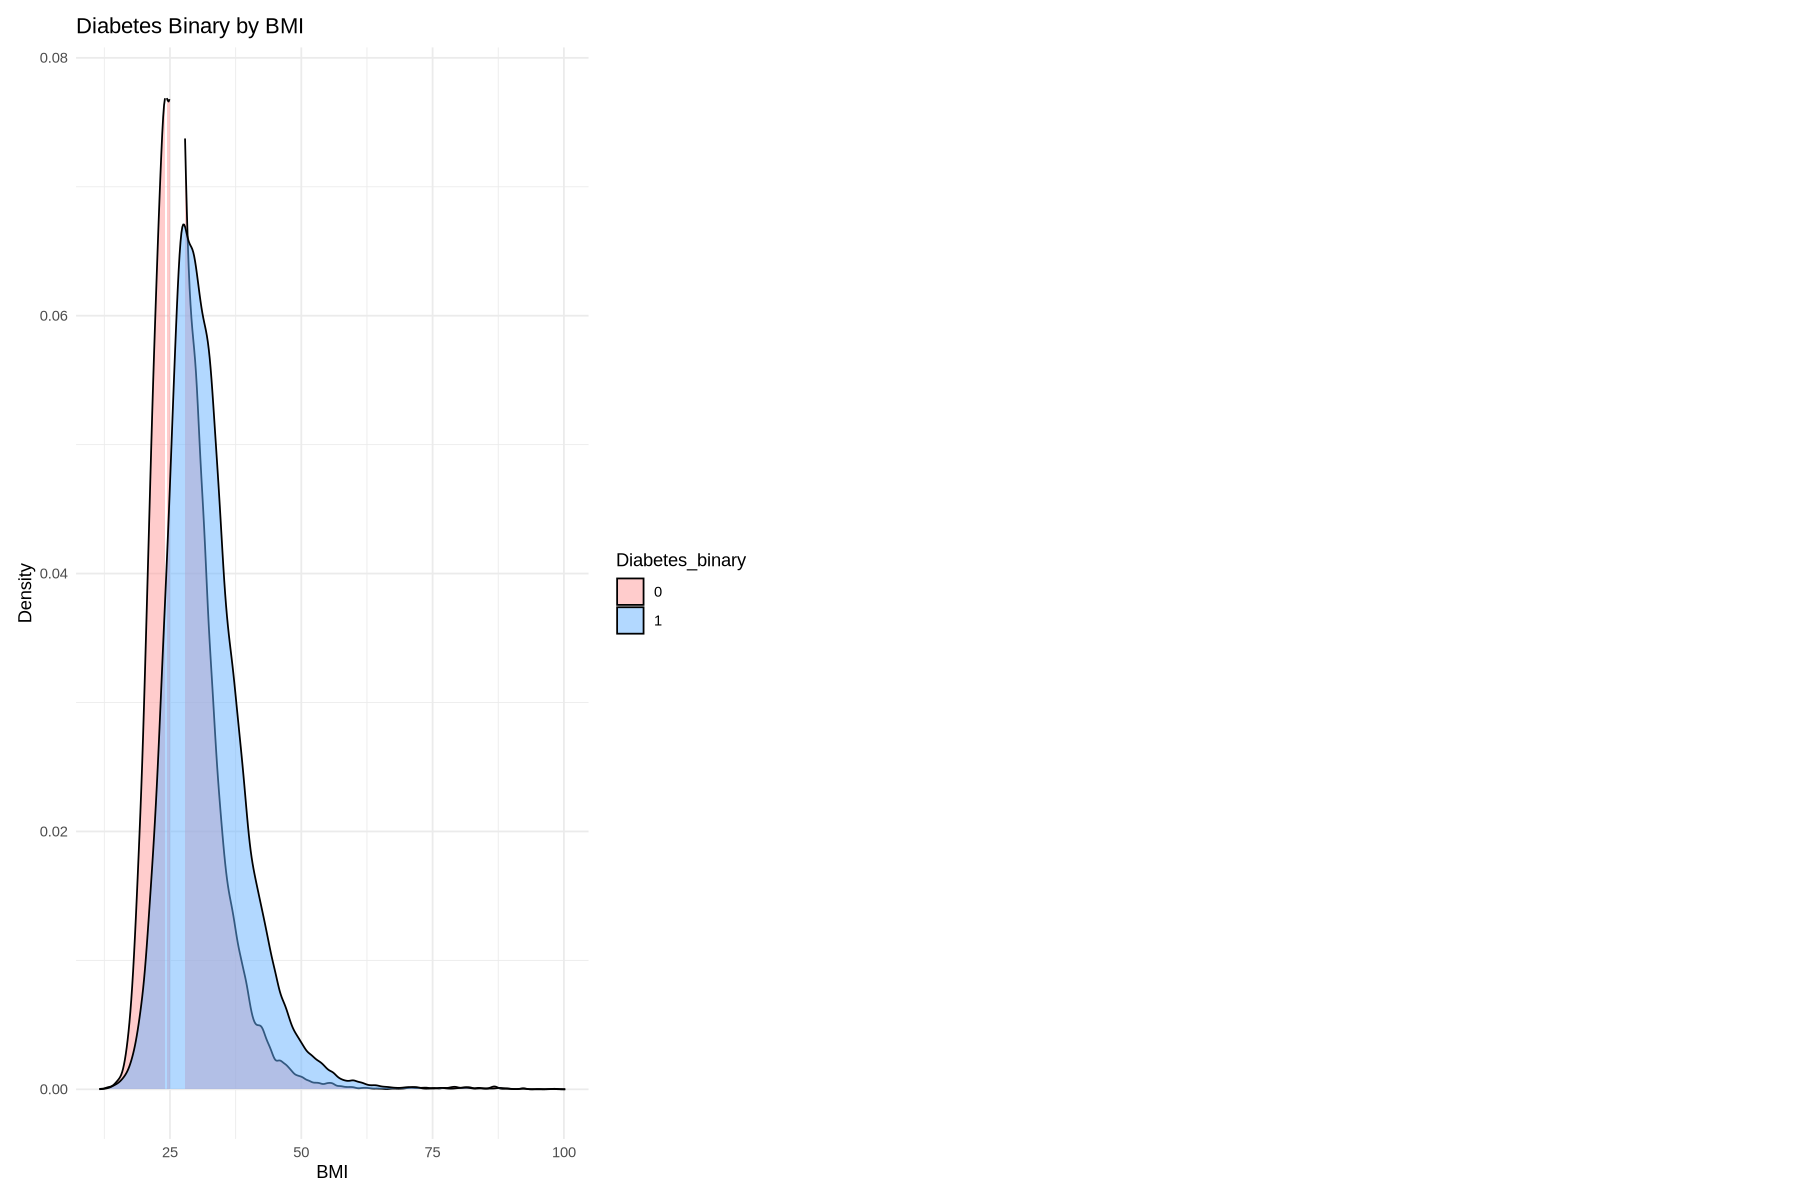

In [21]:
# binary
binary_vars <- c("HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", 
                      "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", 
                      "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", 
                      "DiffWalk", "Sex", "Age", "Education", "Income", "MentHlth", "PhysHlth", "GenHlth")

# not binary
nonbinary_var <- c("BMI")


# --------------------------------------------------
# inits
bar_plots <- list()
density_plots <- list()

# --------------------------------------------------
# Bar plots
for (var in binary_vars) {
  p <- ggplot(diabetes_train, aes(x = !!sym(var), fill = as.factor(Diabetes_binary))) +
    geom_bar(position = "fill") + 
    scale_fill_manual(values = c("#FF9999", "#66B2FF")) + 
    labs(title = paste("Diabetes Binary by", var),
         x = var,
         y = "Proportion",
         fill = "Diabetes_binary") +
    theme_minimal()
  bar_plots[[var]] <- p
}


# --------------------------------------------------
# Density plots

# same y limit
max_density <- 0
for (var in nonbinary_var) {
  density_data <- density(diabetes_train[[var]])
  max_density <- max(max_density, max(density_data$y))
}

buffer <- max_density * 0.70 
max_density_with_buffer <- max_density + buffer


for (var in nonbinary_var) {
  p <- ggplot(diabetes_train, aes(x = !!sym(var), fill = as.factor(Diabetes_binary))) +
    geom_density(alpha = 0.5) +
    scale_fill_manual(values = c("#FF9999", "#66B2FF")) + 
    labs(title = paste("Diabetes Binary by", var),
         x = var,
         y = "Density",
         fill = "Diabetes_binary") +
    ylim(0, max_density) +  
    theme_minimal()
  density_plots[[var]] <- p
}

# ----------------------------------------------------------------------------------------------
combined_bar_plots <- wrap_plots(bar_plots, ncol = 3)  
combined_density_plots <- wrap_plots(density_plots, ncol = 3) 

print(combined_bar_plots, width = 15, height = 20)  # Adjust width and height as needed
print(combined_density_plots, width = 15, height = 8)  # Adjust width and height as needed

### (4) Apply Classification - Logistic Regression
- Create logistic regression model, with `Diabetes_binary` as the prediction variable.
- All numeric predictor variables are normalised with `step_normalize()`.
- All nominal predictor variables have one-hot encoding applied through `step_dummy()`.

In [5]:
set.seed(6)

# prepare model

# recipe
my_rec <- recipe(Diabetes_binary ~ ., data = diabetes_train) %>% 
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())  %>%
    step_zv(all_predictors())


# choose model, penalty + misture will be tune
glm_spec <- logistic_reg(penalty = tune(),
                         mixture = tune()) %>% 
  set_engine("glmnet")

# workflow
glm_wf <- workflow() %>% 
  add_recipe(my_rec) %>% 
  add_model(glm_spec)


# cross validation
set.seed(6)
train_fold <- diabetes_train %>% 
  vfold_cv(5, strata = Diabetes_binary)

In [6]:
# tuning setup

glmn_set <- parameters(penalty(range = c(-5,1)), mixture())

glmn_grid <- grid_regular(glmn_set, levels = c(7, 5))

mset <- metric_set(roc_auc,accuracy, recall)

ctrl <- control_grid(save_pred = TRUE, verbose = FALSE)

In [7]:
# actual running the tune 

glmn_tune <- 
  tune_grid(glm_wf,
            resamples = train_fold,
            grid = glmn_grid,
            metrics = mset,
            control = ctrl)

In [9]:
# create the final model

best_glmn <- select_best(glmn_tune, metric = "recall")

glm_wf_final <- glm_wf %>%
  finalize_workflow(best_glmn) %>%  
  fit(data = diabetes_train) 

In [10]:
# confusion matrix

glm_rs <-  glm_wf_final %>% 
  fit_resamples(
    resamples = train_fold,
    metrics = metric_set(roc_auc, accuracy, recall),
    control = control_resamples(save_pred = TRUE)
  )


collect_metrics(glm_rs)

glm_rs %>% 
  conf_mat_resampled()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5001734,5,2.627984e-06,Preprocessor1_Model1
recall,binary,1.0000000,5,0.000000e+00,Preprocessor1_Model1
roc_auc,binary,0.5000000,5,0.000000e+00,Preprocessor1_Model1


Prediction,Truth,Freq
<fct>,<fct>,<dbl>
0,0,19032.6
0,1,19019.4
1,0,0.0
1,1,0.0


### Metrics for classification:
- 

In [45]:
predictions <- predict(final_model, new_data = diabetes_test, type = "class") %>%
    bind_cols(diabetes_test)

accuracy_result <- predictions %>%
    accuracy(truth = Diabetes_binary, estimate = .pred_class)

precision_result <- predictions %>%
    precision(truth = Diabetes_binary, estimate = .pred_class)

recall_result <- predictions %>%
    recall(truth = Diabetes_binary, estimate = .pred_class)

f1_result <- predictions %>%
    f_meas(truth = Diabetes_binary, estimate = .pred_class)

metrics_table <- bind_rows(
  accuracy_result %>% mutate(.metric = "Accuracy"),
  precision_result %>% mutate(.metric = "Precision"),
  recall_result %>% mutate(.metric = "Recall"),
  f1_result %>% mutate(.metric = "F1 Score")
)
metrics_table

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
Accuracy,binary,0.5001734
Precision,binary,0.5001734
Recall,binary,1.0000000
F1 Score,binary,0.6668208


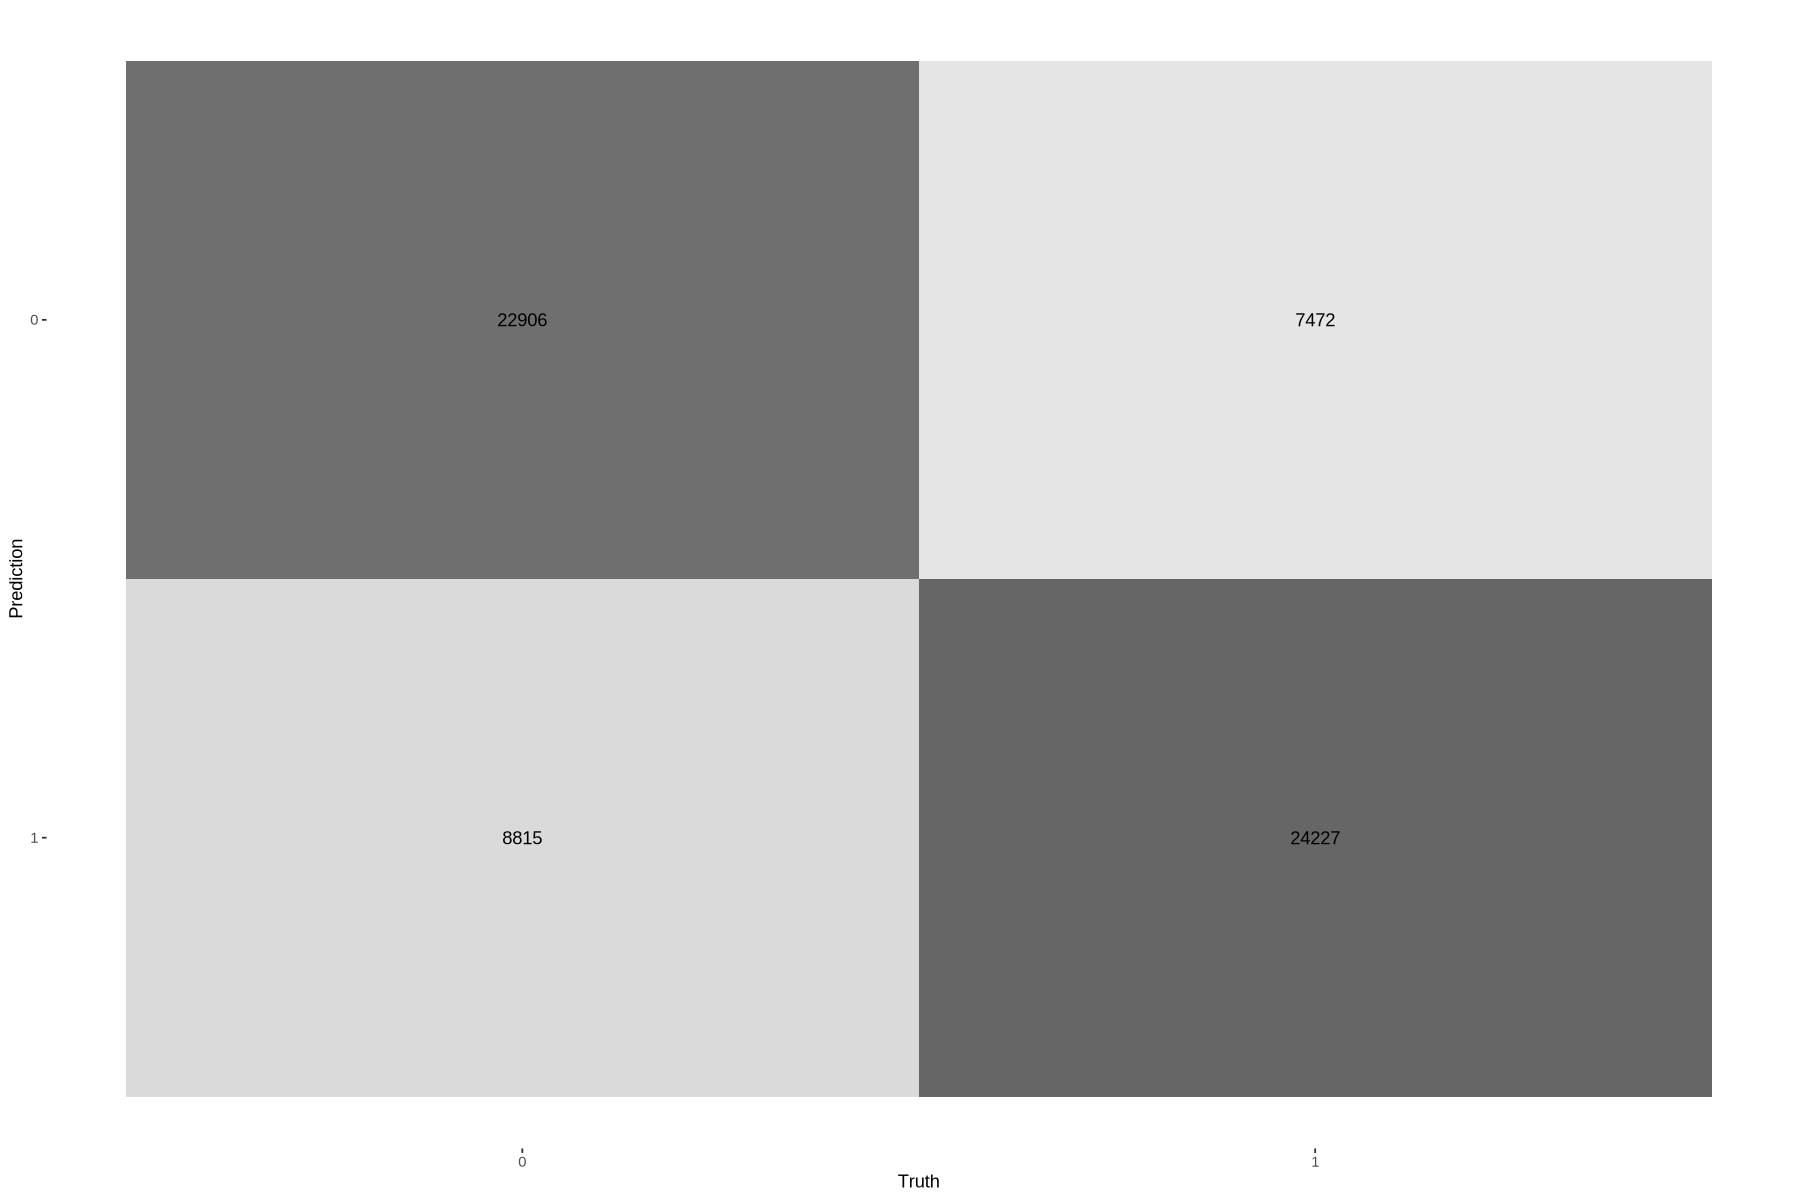

In [22]:
conf_matrix <- predictions %>% 
    conf_mat(truth = Diabetes_binary, estimate = .pred_class)
autoplot(conf_matrix, type = "heatmap")

### Visualisation 
- 

## Discussion


## References
- Centers for Disease Control and Prevention. (2023, September 25). CDC diabetes health indicators. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
- Centers for Disease Control and Prevention. (2017, August 11). CDC - 2015 BRFSS survey data and Documentation. https://www.cdc.gov/brfss/annual_data/annual_2015.html
- Burrows, N. R., Hora, I., Geiss, L. S., Gregg, E. W., & Albright, A. (2017, November 2). Incidence of End-Stage Renal Disease Attributed to Diabetes Among Persons with Diagnosed Diabetes — United States and Puerto Rico, 2000–2014. MMWR Morb Mortal Wkly Rep 2017. http://dx.doi.org/10.15585/mmwr.mm6643a2